In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time # To time training

# --- Configuration ---
DATA_FILE_PATH = './CMaps/train_FD001.txt' # Adjust if your path is different
RUL_CAP = 130 # Cap RUL as before
SEQUENCE_LENGTH = 1 # Using MLP, so sequence length is 1 (predicting from current cycle)
VAL_SPLIT_SIZE = 0.2
RANDOM_STATE = 42

# --- Load Data ---
print("Loading data...")
try:
    train_df = pd.read_csv(DATA_FILE_PATH, sep=' ', header=None)
    # Drop the last two columns (NaN values due to extra spaces)
    train_df.drop(columns=[26, 27], inplace=True)
    # Assign column names
    columns = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3'] + \
              [f'sensor{i}' for i in range(1, 22)]
    train_df.columns = columns
    print(f"Data loaded successfully from {DATA_FILE_PATH}")
except FileNotFoundError:
    print(f"Error: Data file not found at {DATA_FILE_PATH}")
    print("Please ensure the CMaps data is available at the specified path.")
    exit() # Exit if data is not found

# --- Compute RUL ---
print("Computing RUL...")
max_cycles = train_df.groupby('engine_id')['cycle'].max()
def compute_rul(row):
    max_cycle = max_cycles[row['engine_id']]
    rul = max_cycle - row['cycle']
    return min(rul, RUL_CAP) # Cap RUL

train_df['RUL'] = train_df.apply(compute_rul, axis=1)

# --- Define Features ---
features = ['setting1', 'setting2', 'setting3'] + [f'sensor{i}' for i in range(1, 22)]
print(f"Using {len(features)} features: {features}")

# --- Split Data by Engines ---
print("Splitting data by engine ID...")
engine_ids = train_df['engine_id'].unique()
train_engines, val_engines = train_test_split(engine_ids, test_size=VAL_SPLIT_SIZE, random_state=RANDOM_STATE)

train_data = train_df[train_df['engine_id'].isin(train_engines)].copy()
val_data = train_df[train_df['engine_id'].isin(val_engines)].copy()

# --- Extract Features and Targets ---
X_train_raw = train_data[features].values
y_train = train_data['RUL'].values.reshape(-1, 1) # Ensure y is a column vector

X_val_raw = val_data[features].values
y_val = val_data['RUL'].values.reshape(-1, 1) # Ensure y is a column vector

# --- Normalize Features ---
print("Scaling features...")
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)

print("\nData preprocessing complete:")
print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")

Loading data...
Data loaded successfully from ./CMaps/train_FD001.txt
Computing RUL...
Using 24 features: ['setting1', 'setting2', 'setting3', 'sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor10', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20', 'sensor21']
Splitting data by engine ID...
Scaling features...

Data preprocessing complete:
Training samples: 16561, Validation samples: 4070
Number of features: 24


SVM(SVR) Implementation

In [46]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import time

# --- SVM (SVR) Model ---
print("\n--- Training Support Vector Regressor (SVR) ---")

# Initialize SVR model
# Common kernels: 'linear', 'poly', 'rbf' (default), 'sigmoid'
# C: Regularization parameter
# Epsilon: Specifies the epsilon-tube within which no penalty is associated
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Train the SVR model
start_time = time.time()
# SVR expects a 1D array for y, so we use .ravel()
svr_model.fit(X_train, y_train.ravel())
end_time = time.time()
svr_training_time = end_time - start_time
print(f"SVR training completed in {svr_training_time:.2f} seconds.")

# Make predictions on the validation set
y_pred_svr = svr_model.predict(X_val)

# Evaluate the model
svr_mse = mean_squared_error(y_val, y_pred_svr)
svr_rmse = np.sqrt(svr_mse)
print(f"SVR Validation MSE: {svr_mse:.4f}")
print(f"SVR Validation RMSE: {svr_rmse:.4f}")

# Store results for final comparison
results = {
    'SVR': {'val_mse': svr_mse, 'val_rmse': svr_rmse, 'train_time': svr_training_time}
}



--- Training Support Vector Regressor (SVR) ---
SVR training completed in 4.19 seconds.
SVR Validation MSE: 374.6194
SVR Validation RMSE: 19.3551


MLP and AdamW Implementation (from scratch)

In [47]:

# --- Activation Function ---
def relu(x):
    """ReLU activation function."""
    return np.maximum(0, x)

def relu_derivative(x):
    """Derivative of the ReLU activation function."""
    return (x > 0).astype(float)

# --- Loss Function ---
def mse_loss(y_true, y_pred):
    """Mean Squared Error loss."""
    return np.mean((y_pred - y_true)**2)

def mse_loss_derivative(y_true, y_pred):
    """Derivative of the Mean Squared Error loss."""
    return 2 * (y_pred - y_true) / y_true.shape[0]

# --- MLP Model (from scratch) ---
class MLP_scratch:
    """A simple Multi-Layer Perceptron implemented with NumPy."""
    def __init__(self, input_size, hidden_sizes, output_size):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes  # Now a list for multiple layers
        self.output_size = output_size
        
        # Initialize weights using He initialization for ReLU
        self.params = {}
        
        # Input layer to first hidden layer
        self.params['W1'] = np.random.randn(self.input_size, self.hidden_sizes[0]) * np.sqrt(2.0 / self.input_size)
        self.params['b1'] = np.zeros((1, self.hidden_sizes[0]))
        
        # Additional hidden layers if any
        for i in range(1, len(self.hidden_sizes)):
            self.params[f'W{i+1}'] = np.random.randn(self.hidden_sizes[i-1], self.hidden_sizes[i]) * np.sqrt(2.0 / self.hidden_sizes[i-1])
            self.params[f'b{i+1}'] = np.zeros((1, self.hidden_sizes[i]))
            
        # Last hidden layer to output layer
        last_idx = len(self.hidden_sizes) + 1
        self.params[f'W{last_idx}'] = np.random.randn(self.hidden_sizes[-1], self.output_size) * np.sqrt(2.0 / self.hidden_sizes[-1])
        self.params[f'b{last_idx}'] = np.zeros((1, self.output_size))
        
        # Store gradients and cache
        self.grads = {k: np.zeros_like(v) for k, v in self.params.items()}
        self.cache = {}
        
    def relu(self, x):
        """Improved ReLU activation with small epsilon to prevent dead neurons."""
        return np.maximum(0.01 * x, x)  # Leaky ReLU
        
    def relu_derivative(self, x):
        """Derivative of the Leaky ReLU activation."""
        dx = np.ones_like(x)
        dx[x < 0] = 0.01
        return dx
        
    def forward(self, X):
        """Performs the forward pass through all layers."""
        self.cache['A0'] = X  # Input
        
        # Loop through all hidden layers
        for i in range(1, len(self.hidden_sizes) + 1):
            self.cache[f'Z{i}'] = np.dot(self.cache[f'A{i-1}'], self.params[f'W{i}']) + self.params[f'b{i}']
            self.cache[f'A{i}'] = self.relu(self.cache[f'Z{i}'])
            
        # Output layer (no activation for regression)
        last_idx = len(self.hidden_sizes) + 1
        self.cache[f'Z{last_idx}'] = np.dot(self.cache[f'A{last_idx-1}'], self.params[f'W{last_idx}']) + self.params[f'b{last_idx}']
        self.cache[f'A{last_idx}'] = self.cache[f'Z{last_idx}']  # Linear activation
        
        return self.cache[f'A{last_idx}']
        
    def backward(self, X, y_true):
        """Improved backpropagation with proper gradient calculation."""
        m = X.shape[0]  # Batch size
        num_layers = len(self.hidden_sizes) + 1
        
        # Output layer gradient
        dA_last = 2 * (self.cache[f'A{num_layers}'] - y_true) / m  # MSE derivative
        
        # Backpropagate through layers
        dA = dA_last
        for i in range(num_layers, 0, -1):
            dZ = dA
            if i != num_layers:  # Apply activation derivative for hidden layers
                dZ = dA * self.relu_derivative(self.cache[f'Z{i}'])
                
            # Gradients for weights and biases
            self.grads[f'W{i}'] = np.dot(self.cache[f'A{i-1}'].T, dZ)
            self.grads[f'b{i}'] = np.sum(dZ, axis=0, keepdims=True)
            
            # Gradient for previous layer
            if i > 1:  # No need for input layer
                dA = np.dot(dZ, self.params[f'W{i}'].T)
                
    def get_params_and_grads(self):
        """Returns parameters and their gradients."""
        return self.params, self.grads
        
    def set_params(self, params):
        """Sets model parameters."""
        self.params = params

# --- AdamW Optimizer (from scratch) ---
class AdamW_scratch:
    """AdamW optimizer implemented with NumPy."""
    def __init__(self, params_dict, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, weight_decay=0.01):
        self.params_dict = params_dict # Dictionary containing parameters {'W1': W1, 'b1': b1, ...}
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.weight_decay = weight_decay # Lambda for weight decay

        # Initialize moment vectors (m and v) and timestep
        self.m = {key: np.zeros_like(param) for key, param in self.params_dict.items()}
        self.v = {key: np.zeros_like(param) for key, param in self.params_dict.items()}
        self.t = 0 # Timestep

    def step(self, grads_dict):
        """Performs a single optimization step."""
        self.t += 1
        updated_params = {}
        
        # Calculate gradient norm for clipping
        grad_norm = np.sqrt(sum(np.sum(np.square(g)) for g in grads_dict.values()))
        clip_value = 5.0  # Threshold for gradient clipping
        
        for key, param in self.params_dict.items():
            if key not in grads_dict or grads_dict[key] is None:
                updated_params[key] = param
                continue
                
            grad = grads_dict[key]
            
            # Gradient clipping
            if grad_norm > clip_value:
                grad = grad * clip_value / grad_norm
                
            # Decoupled weight decay
            param_decayed = param * (1.0 - self.lr * self.weight_decay)
            
            # Adam update
            self.m[key] = self.beta1 * self.m[key] + (1.0 - self.beta1) * grad
            self.v[key] = self.beta2 * self.v[key] + (1.0 - self.beta2) * (grad**2)
            
            # Bias correction
            m_hat = self.m[key] / (1.0 - self.beta1**self.t)
            v_hat = self.v[key] / (1.0 - self.beta2**self.t)
            
            # Update parameters
            updated_params[key] = param_decayed - self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
            
        return updated_params


MLP Training Loop

In [48]:
# --- Training Function for MLP from Scratch ---
def train_mlp_scratch(model, optimizer_class, X_train, y_train, X_val, y_val, epochs=100, batch_size=64, optimizer_config={}):
    """Trains the MLP model implemented from scratch."""
    train_losses = []
    val_losses = []
    n_samples = X_train.shape[0]

    # Initialize optimizer
    params, _ = model.get_params_and_grads() # Get initial parameters
    optimizer = optimizer_class(params, **optimizer_config)

    print(f"Starting training with optimizer config: {optimizer_config}")
    start_time = time.time()

    weight_norms = []
    
    for epoch in range(epochs):
        epoch_train_loss = 0
        
        # Mini-batch processing with shuffling
        permutation = np.random.permutation(n_samples)
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]
        
        for i in range(0, n_samples, batch_size):
            X_batch = X_train_shuffled[i:i+batch_size]
            y_batch = y_train_shuffled[i:i+batch_size]
            
            # Forward pass
            y_pred_batch = model.forward(X_batch)
            
            # Compute loss
            loss = np.mean((y_pred_batch - y_batch)**2)  # MSE loss
            epoch_train_loss += loss * X_batch.shape[0]
            
            # Backward pass
            model.backward(X_batch, y_batch)
            
            # Get gradients
            params, grads = model.get_params_and_grads()
            
            # Track weight norms (for debugging)
            if i == 0 and epoch % 10 == 0:
                weight_norms.append({k: np.linalg.norm(v) for k, v in params.items()})
            
            # Update parameters
            updated_params = optimizer.step(grads)
            model.set_params(updated_params)
        
        # Calculate average training loss
        avg_epoch_train_loss = epoch_train_loss / n_samples
        train_losses.append(avg_epoch_train_loss)
        
        # Validation loss
        y_pred_val = model.forward(X_val)
        val_loss = np.mean((y_pred_val - y_val)**2)
        val_losses.append(val_loss)
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_epoch_train_loss:.4f}, Val Loss: {val_loss:.4f}')
            
            # Calculate and print RMSE
            val_rmse = np.sqrt(val_loss)
            print(f'Validation RMSE: {val_rmse:.4f}')
            
            # Print weight update info if available
            if len(weight_norms) >= 2:
                last_idx = len(weight_norms) - 1
                for k in weight_norms[0].keys():
                    diff = abs(weight_norms[last_idx][k] - weight_norms[last_idx-1][k])
                    print(f'  Weight {k} change: {diff:.6f}')
    
    end_time = time.time()
    training_time = end_time - start_time
    print(f"MLP training completed in {training_time:.2f} seconds.")
    
    # Final evaluation
    y_pred_final_val = model.forward(X_val)
    final_val_mse = np.mean((y_pred_final_val - y_val)**2)
    final_val_rmse = np.sqrt(final_val_mse)
    
    print(f"Final Validation MSE: {final_val_mse:.4f}")
    print(f"Final Validation RMSE: {final_val_rmse:.4f}")
    
    return train_losses, val_losses, final_val_mse, final_val_rmse, training_time
# --- Run MLP Training ---
print("\n--- Training MLP from Scratch ---")

# Model hyperparameters
input_size = X_train.shape[1]
hidden_size = [128, 64]  # Example hidden layer size
output_size = 1 # RUL prediction
epochs = 100
batch_size = 128
learning_rate = 0.01
weight_decay = 0.001 # Weight decay for AdamW

# Optimizer configurations
optimizer_configs = {
    'AdamW_scratch': {
        'lr': learning_rate,
        'beta1': 0.9,
        'beta2': 0.999,
        'epsilon': 1e-8,
        'weight_decay': weight_decay
    },
    'AdamW_scratch_no_momentum': {
        'lr': learning_rate,
        'beta1': 0.0, # Set beta1 to 0 to disable momentum component
        'beta2': 0.999,
        'epsilon': 1e-8,
        'weight_decay': weight_decay
    }
}

mlp_results = {} # Store results for plotting

for name, config in optimizer_configs.items():
    print(f"\nTraining MLP with {name}...")
    # Initialize a fresh model for each optimizer run
    mlp_model = MLP_scratch(input_size, hidden_size, output_size)
    train_loss, val_loss, final_mse, final_rmse, train_time = train_mlp_scratch(
        mlp_model,
        AdamW_scratch, # Pass the optimizer class
        X_train, y_train,
        X_val, y_val,
        epochs=epochs,
        batch_size=batch_size,
        optimizer_config=config # Pass the specific config for this run
    )
    mlp_results[name] = {
        'train_losses': train_loss,
        'val_losses': val_loss,
        'val_mse': final_mse,
        'val_rmse': final_rmse,
        'train_time': train_time
    }
    # Add MLP results to the main results dictionary
    results[name] = mlp_results[name]



--- Training MLP from Scratch ---

Training MLP with AdamW_scratch...
Starting training with optimizer config: {'lr': 0.01, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'weight_decay': 0.001}
Epoch 1/100, Train Loss: 9626.7194, Val Loss: 9480.7463
Validation RMSE: 97.3691
Epoch 10/100, Train Loss: 9620.9573, Val Loss: 9507.1990
Validation RMSE: 97.5049
Epoch 20/100, Train Loss: 9609.4187, Val Loss: 9499.1887
Validation RMSE: 97.4638
  Weight W1 change: 0.010790
  Weight b1 change: 0.104331
  Weight W2 change: 0.034559
  Weight b2 change: 0.073618
  Weight W3 change: 0.020148
  Weight b3 change: 0.010074
Epoch 30/100, Train Loss: 9619.7322, Val Loss: 9507.4681
Validation RMSE: 97.5062
  Weight W1 change: 0.004256
  Weight b1 change: 0.001537
  Weight W2 change: 0.000261
  Weight b2 change: 0.006162
  Weight W3 change: 0.001327
  Weight b3 change: 0.000218
Epoch 40/100, Train Loss: 9615.3274, Val Loss: 9504.5941
Validation RMSE: 97.4915
  Weight W1 change: 0.004507
  Weight b1 change

Advanced Version

In [49]:
# # --- Comprehensive MLP Implementation with Target Normalization ---

# class BatchNormalization:
#     """Batch Normalization layer implementation."""
#     def __init__(self, input_dim, epsilon=1e-5, momentum=0.9):
#         self.epsilon = epsilon
#         self.momentum = momentum
#         self.gamma = np.ones((1, input_dim))
#         self.beta = np.zeros((1, input_dim))
        
#         # For running averages
#         self.running_mean = np.zeros((1, input_dim))
#         self.running_var = np.ones((1, input_dim))
        
#         # For backprop
#         self.cache = None
        
#     def forward(self, x, training=True):
#         if training:
#             # Calculate mean and variance for this batch
#             batch_mean = np.mean(x, axis=0, keepdims=True)
#             batch_var = np.var(x, axis=0, keepdims=True)
            
#             # Update running mean and variance
#             self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * batch_mean
#             self.running_var = self.momentum * self.running_var + (1 - self.momentum) * batch_var
            
#             # Normalize
#             x_normalized = (x - batch_mean) / np.sqrt(batch_var + self.epsilon)
            
#             # Store for backprop
#             self.cache = (x, x_normalized, batch_mean, batch_var)
#         else:
#             # Use running statistics
#             x_normalized = (x - self.running_mean) / np.sqrt(self.running_var + self.epsilon)
        
#         # Scale and shift
#         out = self.gamma * x_normalized + self.beta
#         return out
    
#     def backward(self, dout):
#         x, x_normalized, mean, var = self.cache
#         m = x.shape[0]
        
#         # Gradients for gamma and beta
#         dgamma = np.sum(dout * x_normalized, axis=0, keepdims=True)
#         dbeta = np.sum(dout, axis=0, keepdims=True)
        
#         # Gradient for normalized input
#         dx_normalized = dout * self.gamma
        
#         # Gradient for variance
#         dvar = np.sum(dx_normalized * (x - mean) * -0.5 * np.power(var + self.epsilon, -1.5), axis=0, keepdims=True)
        
#         # Gradient for mean
#         dmean = np.sum(dx_normalized * -1 / np.sqrt(var + self.epsilon), axis=0, keepdims=True) + \
#                 dvar * np.mean(-2 * (x - mean), axis=0, keepdims=True)
        
#         # Gradient for input
#         dx = dx_normalized / np.sqrt(var + self.epsilon) + \
#              dvar * 2 * (x - mean) / m + \
#              dmean / m
        
#         return dx, dgamma, dbeta

# class MLP_advanced:
#     """A Multi-Layer Perceptron with advanced features for better training."""
#     def __init__(self, input_size, hidden_sizes, output_size, use_batch_norm=True, 
#                 dropout_rate=0.2, target_scaler=None):
#         self.input_size = input_size
#         self.hidden_sizes = hidden_sizes  # List for multiple layers
#         self.output_size = output_size
#         self.use_batch_norm = use_batch_norm
#         self.dropout_rate = dropout_rate
#         self.target_scaler = target_scaler  # For scaling/unscaling target values
#         self.training = True
        
#         # Initialize weights using He initialization
#         self.params = {}
        
#         # First layer
#         self.params['W1'] = np.random.randn(self.input_size, self.hidden_sizes[0]) * np.sqrt(2.0 / self.input_size)
#         self.params['b1'] = np.zeros((1, self.hidden_sizes[0]))
        
#         # Batch normalization for each hidden layer
#         self.bn_layers = {}
#         if self.use_batch_norm:
#             for i in range(len(self.hidden_sizes)):
#                 self.bn_layers[f'bn{i+1}'] = BatchNormalization(self.hidden_sizes[i])
        
#         # Additional hidden layers if any
#         for i in range(1, len(self.hidden_sizes)):
#             self.params[f'W{i+1}'] = np.random.randn(self.hidden_sizes[i-1], self.hidden_sizes[i]) * np.sqrt(2.0 / self.hidden_sizes[i-1])
#             self.params[f'b{i+1}'] = np.zeros((1, self.hidden_sizes[i]))
            
#         # Last hidden layer to output layer
#         last_idx = len(self.hidden_sizes) + 1
#         self.params[f'W{last_idx}'] = np.random.randn(self.hidden_sizes[-1], self.output_size) * np.sqrt(2.0 / self.hidden_sizes[-1])
#         self.params[f'b{last_idx}'] = np.zeros((1, self.output_size))
        
#         # Store gradients and cache
#         self.grads = {k: np.zeros_like(v) for k, v in self.params.items()}
#         self.cache = {}
#         self.dropout_masks = {}
        
#     def relu(self, x):
#         """Improved ReLU activation with leakiness to prevent dead neurons."""
#         return np.maximum(0.01 * x, x)  # Leaky ReLU
        
#     def relu_derivative(self, x):
#         """Derivative of the Leaky ReLU activation."""
#         dx = np.ones_like(x)
#         dx[x < 0] = 0.01
#         return dx
        
#     def dropout(self, x):
#         """Apply dropout during training."""
#         if not self.training or self.dropout_rate == 0:
#             return x
        
#         mask = np.random.rand(*x.shape) > self.dropout_rate
#         self.dropout_masks[id(x)] = mask
        
#         # Scale the values that aren't dropped out
#         return (x * mask) / (1 - self.dropout_rate)
    
#     def forward(self, X, training=True):
#         """Performs the forward pass through all layers with batch norm and dropout."""
#         self.training = training
#         self.cache['A0'] = X  # Input
        
#         # Loop through all hidden layers
#         for i in range(1, len(self.hidden_sizes) + 1):
#             # Linear transformation
#             self.cache[f'Z{i}_pre'] = np.dot(self.cache[f'A{i-1}'], self.params[f'W{i}']) + self.params[f'b{i}']
            
#             # Apply batch normalization if enabled
#             if self.use_batch_norm:
#                 self.cache[f'Z{i}'] = self.bn_layers[f'bn{i}'].forward(self.cache[f'Z{i}_pre'], training=self.training)
#             else:
#                 self.cache[f'Z{i}'] = self.cache[f'Z{i}_pre']
            
#             # Apply activation
#             self.cache[f'A{i}_pre_dropout'] = self.relu(self.cache[f'Z{i}'])
            
#             # Apply dropout
#             self.cache[f'A{i}'] = self.dropout(self.cache[f'A{i}_pre_dropout'])
            
#         # Output layer (no activation for regression, no dropout)
#         last_idx = len(self.hidden_sizes) + 1
#         self.cache[f'Z{last_idx}'] = np.dot(self.cache[f'A{last_idx-1}'], 
#                                           self.params[f'W{last_idx}']) + self.params[f'b{last_idx}']
#         self.cache[f'A{last_idx}'] = self.cache[f'Z{last_idx}']  # Linear activation
        
#         return self.cache[f'A{last_idx}']
        
#     def backward(self, X, y_true):
#         """Improved backpropagation with proper gradient calculation."""
#         m = X.shape[0]  # Batch size
#         num_layers = len(self.hidden_sizes) + 1
        
#         # Output layer gradient - MSE loss
#         dA_last = 2 * (self.cache[f'A{num_layers}'] - y_true) / m
        
#         # Backpropagate through layers
#         dA = dA_last
#         for i in range(num_layers, 0, -1):
#             # For output layer, dZ = dA (no activation derivative)
#             if i == num_layers:
#                 dZ = dA
#             else:
#                 # For hidden layers, apply dropout mask and activation derivative
#                 if self.dropout_rate > 0:
#                     mask = self.dropout_masks[id(self.cache[f'A{i}_pre_dropout'])]
#                     dA = dA * mask / (1 - self.dropout_rate)
                
#                 # Apply activation derivative
#                 dZ = dA * self.relu_derivative(self.cache[f'Z{i}'])
                
#                 # If using batch norm, backprop through the normalization layer
#                 if self.use_batch_norm:
#                     dZ, dgamma, dbeta = self.bn_layers[f'bn{i}'].backward(dZ)
#                     # Update batch norm parameters
#                     self.grads[f'gamma{i}'] = dgamma
#                     self.grads[f'beta{i}'] = dbeta
            
#             # Gradients for weights and biases
#             self.grads[f'W{i}'] = np.dot(self.cache[f'A{i-1}'].T, dZ)
#             self.grads[f'b{i}'] = np.sum(dZ, axis=0, keepdims=True)
            
#             # Gradient for previous layer
#             if i > 1:  # No need for input layer
#                 dA = np.dot(dZ, self.params[f'W{i}'].T)
                
#     def get_params_and_grads(self):
#         """Returns parameters and their gradients."""
#         return self.params, self.grads
        
#     def set_params(self, params):
#         """Sets model parameters."""
#         self.params = params
        
#     def predict(self, X):
#         """Make predictions with the model, including inverse scaling if needed."""
#         predictions = self.forward(X, training=False)
#         if self.target_scaler is not None:
#             # Reshape predictions to match scaler's expected format
#             orig_shape = predictions.shape
#             flat_preds = predictions.reshape(-1, 1)
#             # Inverse transform
#             unscaled_preds = self.target_scaler.inverse_transform(flat_preds)
#             # Reshape back to original shape
#             return unscaled_preds.reshape(orig_shape)
#         return predictions

# # --- Learning Rate Scheduler ---
# class LearningRateScheduler:
#     """Learning rate scheduler with various strategies."""
#     def __init__(self, initial_lr=0.01, strategy='step', 
#                  decay_rate=0.5, decay_steps=50, min_lr=0.0001):
#         self.initial_lr = initial_lr
#         self.strategy = strategy
#         self.decay_rate = decay_rate
#         self.decay_steps = decay_steps
#         self.min_lr = min_lr
#         self.current_lr = initial_lr
        
#     def get_lr(self, epoch):
#         """Get learning rate for current epoch."""
#         if self.strategy == 'step':
#             # Step decay: lr = initial_lr * decay_rate^(epoch / decay_steps)
#             self.current_lr = self.initial_lr * (self.decay_rate ** (epoch // self.decay_steps))
#         elif self.strategy == 'exponential':
#             # Exponential decay: lr = initial_lr * exp(-decay_rate * epoch)
#             self.current_lr = self.initial_lr * np.exp(-self.decay_rate * epoch)
#         elif self.strategy == 'cosine':
#             # Cosine annealing: lr = min_lr + 0.5 * (initial_lr - min_lr) * (1 + cos(epoch / max_epochs * pi))
#             max_epochs = 500  # Hardcoded for now
#             cosine_decay = 0.5 * (1 + np.cos(np.pi * epoch / max_epochs))
#             self.current_lr = self.min_lr + (self.initial_lr - self.min_lr) * cosine_decay
        
#         # Ensure learning rate doesn't go below minimum
#         return max(self.current_lr, self.min_lr)

# # --- Improved AdamW Optimizer with Learning Rate Scheduling ---
# class AdamW_with_scheduler:
#     """AdamW optimizer with learning rate scheduling and gradient clipping."""
#     def __init__(self, params_dict, lr_scheduler, beta1=0.9, beta2=0.999, 
#                  epsilon=1e-8, weight_decay=0.01, clip_value=5.0):
#         self.params_dict = params_dict
#         self.lr_scheduler = lr_scheduler
#         self.current_lr = lr_scheduler.current_lr
#         self.beta1 = beta1
#         self.beta2 = beta2
#         self.epsilon = epsilon
#         self.weight_decay = weight_decay
#         self.clip_value = clip_value
        
#         # Initialize moment vectors
#         self.m = {k: np.zeros_like(v) for k, v in self.params_dict.items()}
#         self.v = {k: np.zeros_like(v) for k, v in self.params_dict.items()}
#         self.t = 0
        
#     def step(self, grads_dict, epoch):
#         """Performs optimization step with learning rate scheduling and gradient clipping."""
#         self.t += 1
#         updated_params = {}
        
#         # Update learning rate based on scheduler
#         self.current_lr = self.lr_scheduler.get_lr(epoch)
        
#         # Calculate gradient norm for clipping
#         grad_list = [g for k, g in grads_dict.items() if k in self.params_dict and g is not None]
#         if grad_list:
#             grad_norm = np.sqrt(sum(np.sum(np.square(g)) for g in grad_list))
#             clip_scale = min(1.0, self.clip_value / (grad_norm + 1e-6))
#         else:
#             clip_scale = 1.0
        
#         for key, param in self.params_dict.items():
#             if key not in grads_dict or grads_dict[key] is None:
#                 updated_params[key] = param
#                 continue
                
#             grad = grads_dict[key]
            
#             # Apply gradient clipping
#             grad = grad * clip_scale
                
#             # Decoupled weight decay - only apply to weight matrices, not biases or batch norm params
#             if 'W' in key:
#                 param_decayed = param * (1.0 - self.current_lr * self.weight_decay)
#             else:
#                 param_decayed = param
            
#             # Adam update
#             self.m[key] = self.beta1 * self.m[key] + (1.0 - self.beta1) * grad
#             self.v[key] = self.beta2 * self.v[key] + (1.0 - self.beta2) * (grad**2)
            
#             # Bias correction
#             m_hat = self.m[key] / (1.0 - self.beta1**self.t)
#             v_hat = self.v[key] / (1.0 - self.beta2**self.t)
            
#             # Update parameters
#             updated_params[key] = param_decayed - self.current_lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
            
#         return updated_params

# # --- Comprehensive Training Function with Proper Target Normalization ---
# def train_mlp_advanced(model, optimizer_class, X_train, y_train, X_val, y_val, 
#                       epochs=500, batch_size=64, optimizer_config={}):
#     """Advanced training function with proper monitoring and debugging."""
#     train_losses = []
#     val_losses = []
#     train_rmse = []
#     val_rmse = []
#     n_samples = X_train.shape[0]
    
#     # Create target scaler if not already provided to model
#     if model.target_scaler is None:
#         from sklearn.preprocessing import StandardScaler
#         target_scaler = StandardScaler()
#         # Fit the scaler on training targets
#         y_train_flat = y_train.reshape(-1, 1)
#         target_scaler.fit(y_train_flat)
#         # Assign to model
#         model.target_scaler = target_scaler
    
#     # Scale targets for training
#     y_train_scaled = model.target_scaler.transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
#     y_val_scaled = model.target_scaler.transform(y_val.reshape(-1, 1)).reshape(y_val.shape)
    
#     # Initialize learning rate scheduler
#     lr_scheduler = LearningRateScheduler(
#         initial_lr=optimizer_config.get('lr', 0.01),
#         strategy=optimizer_config.get('lr_strategy', 'cosine'),
#         decay_rate=optimizer_config.get('decay_rate', 0.5),
#         decay_steps=optimizer_config.get('decay_steps', 50),
#         min_lr=optimizer_config.get('min_lr', 0.0001)
#     )
    
#     # Initialize optimizer
#     params, _ = model.get_params_and_grads()
#     optimizer = optimizer_class(params, lr_scheduler=lr_scheduler, 
#                                beta1=optimizer_config.get('beta1', 0.9),
#                                beta2=optimizer_config.get('beta2', 0.999),
#                                epsilon=optimizer_config.get('epsilon', 1e-8),
#                                weight_decay=optimizer_config.get('weight_decay', 0.001),
#                                clip_value=optimizer_config.get('clip_value', 5.0))
    
#     print(f"Starting advanced training with normalized targets")
#     print(f"Optimizer config: {optimizer_config}")
#     print(f"Model architecture: Input({X_train.shape[1]}) -> Hidden{model.hidden_sizes} -> Output({y_train.shape[1]})")
#     print(f"Target scaling: Mean={model.target_scaler.mean_[0]:.2f}, Std={model.target_scaler.scale_[0]:.2f}")
    
#     start_time = time.time()
    
#     # Track weight norms and learning rates
#     weight_norms = []
#     learning_rates = []
    
#     for epoch in range(epochs):
#         epoch_train_loss = 0
        
#         # Track current learning rate
#         learning_rates.append(optimizer.current_lr)
        
#         # Mini-batch processing with shuffling
#         permutation = np.random.permutation(n_samples)
#         X_train_shuffled = X_train[permutation]
#         y_train_scaled_shuffled = y_train_scaled[permutation]
        
#         for i in range(0, n_samples, batch_size):
#             X_batch = X_train_shuffled[i:i+batch_size]
#             y_batch = y_train_scaled_shuffled[i:i+batch_size]
            
#             # Forward pass
#             y_pred_batch = model.forward(X_batch, training=True)
            
#             # Compute loss on scaled values
#             loss = np.mean((y_pred_batch - y_batch)**2)  # MSE loss on scaled targets
#             epoch_train_loss += loss * X_batch.shape[0]
            
#             # Backward pass
#             model.backward(X_batch, y_batch)
            
#             # Get gradients
#             params, grads = model.get_params_and_grads()
            
#             # Track weight norms (for debugging)
#             if i == 0 and epoch % 10 == 0:
#                 weight_norm = {k: np.linalg.norm(v) for k, v in params.items() if 'W' in k}
#                 weight_norms.append(weight_norm)
            
#             # Update parameters with current epoch for learning rate scheduling
#             updated_params = optimizer.step(grads, epoch)
#             model.set_params(updated_params)
        
#         # Calculate average training loss
#         avg_epoch_train_loss = epoch_train_loss / n_samples
#         train_losses.append(avg_epoch_train_loss)
        
#         # Validation loss (on scaled values)
#         y_pred_val_scaled = model.forward(X_val, training=False)
#         val_loss = np.mean((y_pred_val_scaled - y_val_scaled)**2)
#         val_losses.append(val_loss)
        
#         # Calculate RMSE on original scale for monitoring
#         # For training data
#         y_pred_train = model.predict(X_train[:1000])  # Use subset for efficiency
#         train_mse_orig = np.mean((y_pred_train - y_train[:1000])**2)
#         train_rmse_value = np.sqrt(train_mse_orig)
#         train_rmse.append(train_rmse_value)
        
#         # For validation data
#         y_pred_val = model.predict(X_val)
#         val_mse_orig = np.mean((y_pred_val - y_val)**2)
#         val_rmse_value = np.sqrt(val_mse_orig)
#         val_rmse.append(val_rmse_value)
        
#         if (epoch + 1) % 10 == 0 or epoch == 0:
#             print(f'Epoch {epoch+1}/{epochs}:')
#             print(f'  Train Loss (scaled): {avg_epoch_train_loss:.4f}, Val Loss (scaled): {val_loss:.4f}')
#             print(f'  Train RMSE (orig): {train_rmse_value:.4f}, Val RMSE (orig): {val_rmse_value:.4f}')
#             print(f'  Learning Rate: {optimizer.current_lr:.6f}')
            
#             # Print weight update info if available
#             if len(weight_norms) >= 2:
#                 last_idx = len(weight_norms) - 1
#                 for k in weight_norms[0].keys():
#                     diff = abs(weight_norms[last_idx][k] - weight_norms[last_idx-1][k])
#                     if diff > 0:
#                         print(f'  Weight {k} change: {diff:.6f}')
    
#     end_time = time.time()
#     training_time = end_time - start_time
#     print(f"MLP training completed in {training_time:.2f} seconds.")
    
#     # Final evaluation
#     y_pred_final_val = model.predict(X_val)  # This includes inverse scaling
#     final_val_mse = np.mean((y_pred_final_val - y_val)**2)
#     final_val_rmse = np.sqrt(final_val_mse)
    
#     print(f"Final Validation MSE (original scale): {final_val_mse:.4f}")
#     print(f"Final Validation RMSE (original scale): {final_val_rmse:.4f}")
    
#     return train_losses, val_losses, train_rmse, val_rmse, final_val_mse, final_val_rmse, training_time


# # """
# # Set up target scaler (will be done automatically in train_mlp_advanced)
# from sklearn.preprocessing import StandardScaler
# target_scaler = StandardScaler()

# # Define model with multiple hidden layers
# input_size = X_train.shape[1]  # Number of features
# hidden_sizes = [256, 128, 64]  # Three hidden layers
# output_size = 1  # RUL prediction

# # Create model
# mlp_model = MLP_advanced(
#     input_size, 
#     hidden_sizes, 
#     output_size,
#     use_batch_norm=True,  # Use batch normalization
#     dropout_rate=0.2,     # Apply dropout for regularization
#     target_scaler=None    # Will be created in training function
# )

# # Define optimizer config with learning rate scheduling
# optimizer_config = {
#     'lr': 0.01,
#     'lr_strategy': 'cosine',  # Options: 'step', 'exponential', 'cosine'
#     'decay_rate': 0.5,
#     'decay_steps': 50,
#     'min_lr': 0.0001,
#     'beta1': 0.9,
#     'beta2': 0.999,
#     'epsilon': 1e-8,
#     'weight_decay': 0.001,
#     'clip_value': 5.0
# }

# # Train the model
# train_losses, val_losses, train_rmse, val_rmse, final_mse, final_rmse, train_time = train_mlp_advanced(
#     mlp_model,
#     AdamW_with_scheduler,
#     X_train, y_train,
#     X_val, y_val,
#     epochs=500,
#     batch_size=128,
#     optimizer_config=optimizer_config
# )
# # """

Plotting results


--- Plotting MLP Training Results ---


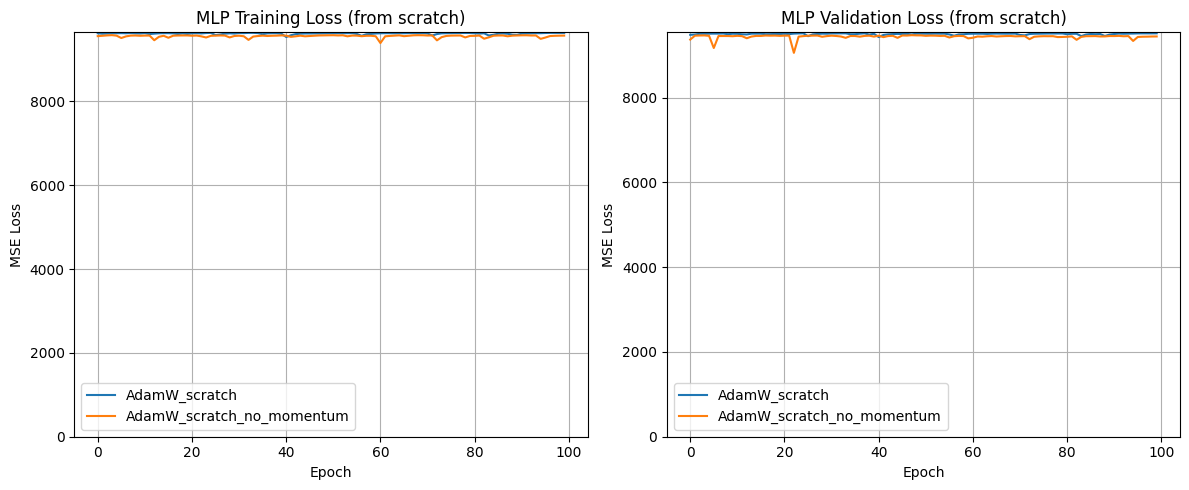


--- Plotting Final Model Comparison ---


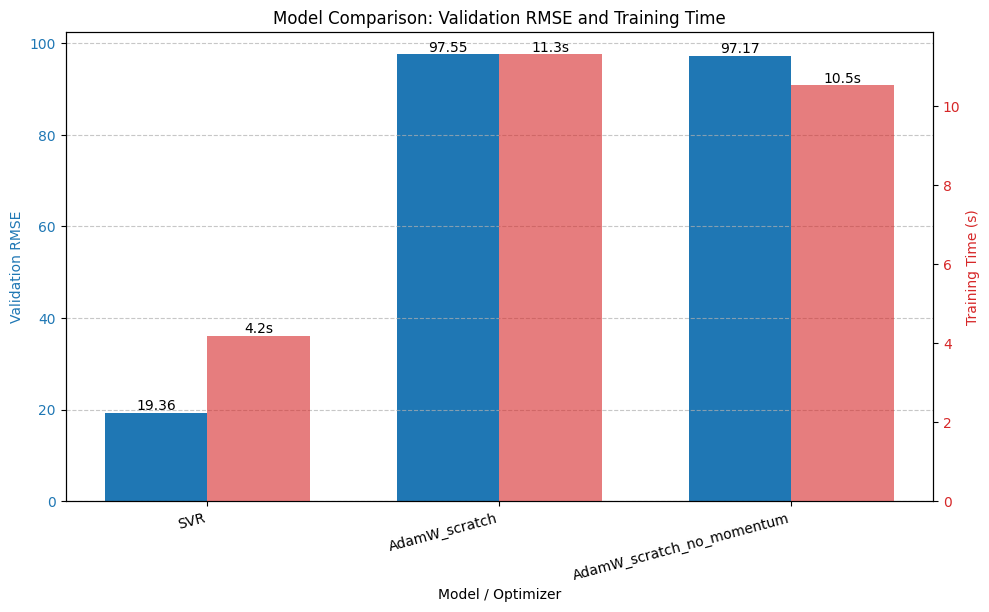


Comparison Results:
- SVR: Validation RMSE = 19.3551, Training Time = 4.19s
- AdamW_scratch: Validation RMSE = 97.5506, Training Time = 11.32s
- AdamW_scratch_no_momentum: Validation RMSE = 97.1718, Training Time = 10.53s


In [50]:


# --- Plot MLP Loss Curves ---
print("\n--- Plotting MLP Training Results ---")
plt.figure(figsize=(12, 5))

# Plot Training Losses
plt.subplot(1, 2, 1)
for name, data in mlp_results.items():
    plt.plot(data['train_losses'], label=f'{name}')
plt.title('MLP Training Loss (from scratch)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.ylim(bottom=0) # Ensure y-axis starts at 0

# Plot Validation Losses
plt.subplot(1, 2, 2)
for name, data in mlp_results.items():
    plt.plot(data['val_losses'], label=f'{name}')
plt.title('MLP Validation Loss (from scratch)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.ylim(bottom=0) # Ensure y-axis starts at 0

plt.tight_layout()
plt.show()

# --- Plot Final Comparison ---
print("\n--- Plotting Final Model Comparison ---")

model_names = list(results.keys())
final_rmse = [results[name]['val_rmse'] for name in model_names]
training_times = [results[name]['train_time'] for name in model_names]

x = np.arange(len(model_names)) # the label locations
width = 0.35 # the width of the bars

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for RMSE
color = 'tab:blue'
ax1.set_xlabel('Model / Optimizer')
ax1.set_ylabel('Validation RMSE', color=color)
bars1 = ax1.bar(x - width/2, final_rmse, width, label='Validation RMSE', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=15, ha='right')
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add RMSE values on top of bars
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom', ha='center') # va: vertical alignment

# Bar chart for Training Time (on secondary axis)
ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Training Time (s)', color=color) # we already handled the x-label with ax1
bars2 = ax2.bar(x + width/2, training_times, width, label='Training Time (s)', color=color, alpha=0.6)
ax2.tick_params(axis='y', labelcolor=color)

# Add Training Time values on top of bars
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.1f}s', va='bottom', ha='center') # va: vertical alignment


fig.tight_layout() # otherwise the right y-label is slightly clipped
plt.title('Model Comparison: Validation RMSE and Training Time')
# Adding legends (might get crowded, consider commenting out if needed)
# fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

print("\nComparison Results:")
for name, data in results.items():
    print(f"- {name}: Validation RMSE = {data['val_rmse']:.4f}, Training Time = {data['train_time']:.2f}s")

